# POS Tagging Analysis on Spotify Reviews

This notebook runs structured POS tagging on all Spotify reviews using the existing spaCy pipeline with custom EntityRuler. We extract token-level data, visualize tag distributions, measure sentence-level tag diversity, and find representative sentences per POS type.

In [1]:
# ── Imports & Setup ────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import re
import spacy
import contractions
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from collections import Counter
from spacy.pipeline import EntityRuler

warnings.filterwarnings('ignore')

# ── Load spaCy model ───────────────────────────────────────────────────────────
nlp = spacy.load("en_core_web_sm")

# ── Add custom EntityRuler for brand names ─────────────────────────────────────
if "entity_ruler" not in nlp.pipe_names:
    ruler = nlp.add_pipe("entity_ruler", before="ner")
else:
    ruler = nlp.get_pipe("entity_ruler")

patterns = [
    {"label": "ORG", "pattern": "Spotify"},
    {"label": "ORG", "pattern": "spotify"},
    {"label": "ORG", "pattern": "Apple Music"},
    {"label": "ORG", "pattern": "Google Play"},
]
ruler.add_patterns(patterns)

# ── Load & preprocess data ──────────────────────────────────────────────────────
df = pd.read_csv('../Data/spotify_reviews.csv')

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)
    text = contractions.fix(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    return ' '.join(text.split())

df['cleaned'] = df['Content'].apply(preprocess_text)

# ── Build capitalization map ────────────────────────────────────────────────────
capitalization_map = {}
for raw_text in df['Content'].head(500):
    for word in raw_text.split():
        clean_word = word.rstrip(',.!?;:')
        lower_word = clean_word.lower()
        if clean_word and clean_word[0].isupper() and len(clean_word) > 1:
            if lower_word not in capitalization_map:
                capitalization_map[lower_word] = clean_word

def restore_capitalization(text: str) -> str:
    """Restore capitalization for NER processing."""
    words = text.split()
    restored = []
    for word in words:
        clean_word = word.rstrip(',.!?;:')
        punct = word[len(clean_word):]
        if clean_word.lower() in capitalization_map:
            restored.append(capitalization_map[clean_word.lower()] + punct)
        else:
            restored.append(word)
    return ' '.join(restored)

print("=" * 60)
print("✅ Setup Complete")
print("=" * 60)
print(f"  Reviews loaded       : {len(df):,}")
print(f"  spaCy model          : {nlp.meta['name']} v{nlp.meta['version']}")
print(f"  Custom NER patterns  : {len(patterns)}")
print(f"  Capitalization map   : {len(capitalization_map):,} entries")

✅ Setup Complete
  Reviews loaded       : 100
  spaCy model          : core_web_sm v3.8.0
  Custom NER patterns  : 4
  Capitalization map   : 130 entries


## 0️⃣ UPOS vs Penn Treebank Tags — spaCy Linguistic Annotation

spaCy assigns **two** POS tag types to every token:

| Attribute | Tagset | Example | Use case |
|---|---|---|---|
| `token.pos_` | Universal (UPOS) | `NOUN`, `VERB`, `ADJ` | Cross-language, coarse-grained |
| `token.tag_` | Penn Treebank | `NN`, `VBD`, `JJ` | English-specific, fine-grained |

`spacy.explain(token.tag_)` returns a human-readable description of any tag.

In [2]:
# ── UPOS vs Penn Treebank Tag Comparison ──────────────────────────────────────
import spacy

# Use a representative Spotify review sentence for demonstration
text = "The quick brown fox jumps over the lazy dog. Dr. Smith agrees wholeheartedly."
doc  = nlp(text)

# ── Full token analysis table: UPOS + Penn Tag + explanation ─────────────────
print("=" * 80)
print("📋 Token Analysis Table — UPOS vs Penn Treebank Tags")
print("=" * 80)
print(f"\n  {'Token':<14} {'Lemma':<14} {'UPOS':<8} {'Penn Tag':<10} Explanation")
print("  " + "─" * 75)

for token in doc:
    explanation = spacy.explain(token.tag_) or '-'
    print(f"  {token.text:<14} {token.lemma_:<14} {token.pos_:<8} {token.tag_:<10} {explanation}")

# ── Sentence-level access + noun extraction ──────────────────────────────────
print("\n" + "=" * 80)
print("📝 Sentence-Level Analysis")
print("=" * 80)
for i, sent in enumerate(doc.sents):
    print(f"\n  Sentence {i+1}: {sent.text}")
    nouns = [t.text for t in sent if t.pos_ == 'NOUN']
    verbs = [t.text for t in sent if t.pos_ == 'VERB']
    adjs  = [t.text for t in sent if t.pos_ == 'ADJ']
    print(f"    Nouns : {nouns}")
    print(f"    Verbs : {verbs}")
    print(f"    Adjs  : {adjs}")

# ── Key Penn Treebank tags relevant to sentiment analysis ─────────────────────
print("\n" + "=" * 80)
print("💡 Key Penn Tags for Sentiment Analysis")
print("=" * 80)
sentiment_tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NN', 'NNS']
print(f"\n  {'Penn Tag':<10} {'UPOS':<8} Description")
print("  " + "─" * 55)
for tag in sentiment_tags:
    desc = spacy.explain(tag) or '-'
    # Map Penn tag prefix to UPOS
    upos = 'ADJ' if tag.startswith('J') else 'ADV' if tag.startswith('R') else 'VERB' if tag.startswith('V') else 'NOUN'
    print(f"  {tag:<10} {upos:<8} {desc}")

print("\n  → Penn tags give finer detail: e.g. VBD (past tense) vs VBG (gerund)")
print("  → JJR/JJS (comparative/superlative) are strong sentiment signals")
print("  → Use token.tag_ when you need tense, number, or degree information")

📋 Token Analysis Table — UPOS vs Penn Treebank Tags

  Token          Lemma          UPOS     Penn Tag   Explanation
  ───────────────────────────────────────────────────────────────────────────
  The            the            DET      DT         determiner
  quick          quick          ADJ      JJ         adjective (English), other noun-modifier (Chinese)
  brown          brown          ADJ      JJ         adjective (English), other noun-modifier (Chinese)
  fox            fox            NOUN     NN         noun, singular or mass
  jumps          jump           VERB     VBZ        verb, 3rd person singular present
  over           over           ADP      IN         conjunction, subordinating or preposition
  the            the            DET      DT         determiner
  lazy           lazy           ADJ      JJ         adjective (English), other noun-modifier (Chinese)
  dog            dog            NOUN     NN         noun, singular or mass
  .              .              PUNCT   

## 1️⃣ Run POS Tagger & Extract Structured Tags

Using the existing spaCy pipeline with custom `EntityRuler`, run POS tagging on all tokenized sentences. Extract results into a structured DataFrame with columns: `doc_id`, `sentence_id`, `token`, `lemma`, `upos` (Universal POS), `fine_tag` (Penn Treebank), `sent_id` (sentence start char), `pos_tag`. Named entities (e.g. Spotify, Apple Music) are filtered out to avoid polluting the POS distribution.

In [3]:
# ── POS Tagging & Structured Tag Extraction ────────────────────────────────────

records = []

print("=" * 60)
print("🔄 Running POS Tagging on all reviews...")
print("=" * 60)

for doc_id, cleaned_text in enumerate(df['cleaned']):
    # Restore capitalization for proper NER detection
    restored_text = restore_capitalization(cleaned_text)
    doc = nlp(restored_text)

    # Collect named entities to filter out
    named_entities = {token.text.lower() for ent in doc.ents for token in ent}

    for sent_id, sent in enumerate(doc.sents):
        for token in sent:
            # Skip named entities, punctuation, spaces, and numbers
            if token.text.lower() in named_entities:
                continue
            if token.pos_ in ('PUNCT', 'SPACE', 'NUM', 'X', ''):
                continue
            if not token.text.strip():
                continue

            records.append({
                'doc_id'     : doc_id,
                'sentence_id': sent_id,
                'token'      : token.text,
                'lemma'      : token.lemma_,
                'upos'       : token.pos_,          # Universal POS (NOUN, VERB, ADJ …)
                'fine_tag'   : token.tag_,          # Penn Treebank tag (NN, VBD, JJ …)
                'sent_id'    : token.sent.start_char, # Sentence start char offset
                'pos_tag'    : token.pos_,          # Alias kept for downstream cells
                'sentence'   : sent.text.strip(),
            })

# ── Build structured DataFrame ─────────────────────────────────────────────────
pos_df = pd.DataFrame(records)

print(f"\n📊 Structured POS Tag DataFrame")
print(f"  Total token records : {len(pos_df):,}")
print(f"  Unique UPOS tags    : {pos_df['upos'].nunique()}")
print(f"  Unique Penn tags    : {pos_df['fine_tag'].nunique()}")
print(f"  Unique documents    : {pos_df['doc_id'].nunique():,}")
print(f"  Unique sentences    : {pos_df.groupby(['doc_id','sentence_id']).ngroups:,}")
print(f"\nColumn types:\n{pos_df.dtypes}")
print(f"\nSample records (token | lemma | upos | fine_tag | sent_id):")
print(pos_df[['token','lemma','upos','fine_tag','sent_id']].head(10).to_string(index=False))

🔄 Running POS Tagging on all reviews...

📊 Structured POS Tag DataFrame
  Total token records : 2,041
  Unique UPOS tags    : 14
  Unique Penn tags    : 31
  Unique documents    : 100
  Unique sentences    : 211

Column types:
doc_id          int64
sentence_id     int64
token          object
lemma          object
upos           object
fine_tag       object
sent_id         int64
pos_tag        object
sentence       object
dtype: object

Sample records (token | lemma | upos | fine_tag | sent_id):
   token   lemma  upos fine_tag  sent_id
      Is      be   AUX      VBZ        0
    very    very   ADV       RB        0
    good    good   ADJ       JJ        0
     got     get  VERB      VBD        0
    many    many   ADJ       JJ        0
   songs    song  NOUN      NNS        0
     And     and CCONJ       CC        0
suggests suggest  VERB      VBZ        0
     New     new   ADJ       JJ        0
    ones     one  NOUN      NNS        0

📊 Structured POS Tag DataFrame
  Total token rec

In [4]:
# ── Milestone 2 Export — Full Token-Level POS DataFrame ───────────────────────
# Exports the columns required by the milestone deliverable spec:
# token | lemma | upos | fine_tag | sent_id

milestone_cols = ['token', 'lemma', 'upos', 'fine_tag', 'sent_id']
pos_df[milestone_cols].to_csv('../Data/milestone2_pos_analysis.csv', index=False)

print("=" * 60)
print("📋 POS Tag Distribution (Full Corpus)")
print("=" * 60)

tag_counts = pos_df['pos_tag'].value_counts()
total_tokens = len(pos_df)

print(f"\n{'POS Tag':<10} {'Count':>8} {'Percentage':>12}")
print("-" * 34)
for tag, count in tag_counts.items():
    pct = (count / total_tokens) * 100
    print(f"{tag:<10} {count:>8,} {pct:>11.2f}%")

print(f"\n{'TOTAL':<10} {total_tokens:>8,} {'100.00%':>12}")
print(f"\n📁 Milestone export saved to ../Data/milestone2_pos_analysis.csv")
print(f"   Columns : {milestone_cols}")
print(f"   Rows    : {len(pos_df):,}")

📋 POS Tag Distribution (Full Corpus)

POS Tag       Count   Percentage
----------------------------------
NOUN            313       15.34%
VERB            286       14.01%
PRON            225       11.02%
AUX             187        9.16%
ADJ             185        9.06%
ADV             163        7.99%
PROPN           163        7.99%
DET             155        7.59%
ADP             154        7.55%
PART            104        5.10%
CCONJ            56        2.74%
SCONJ            38        1.86%
INTJ             10        0.49%
SYM               2        0.10%

TOTAL         2,041      100.00%

📁 Milestone export saved to ../Data/milestone2_pos_analysis.csv
   Columns : ['token', 'lemma', 'upos', 'fine_tag', 'sent_id']
   Rows    : 2,041


## 2️⃣ Plot Top-10 POS Tag Frequencies

Count POS tag occurrences across the full corpus and visualize as a horizontal bar chart. Bars are annotated with both raw counts and percentage of total tokens.

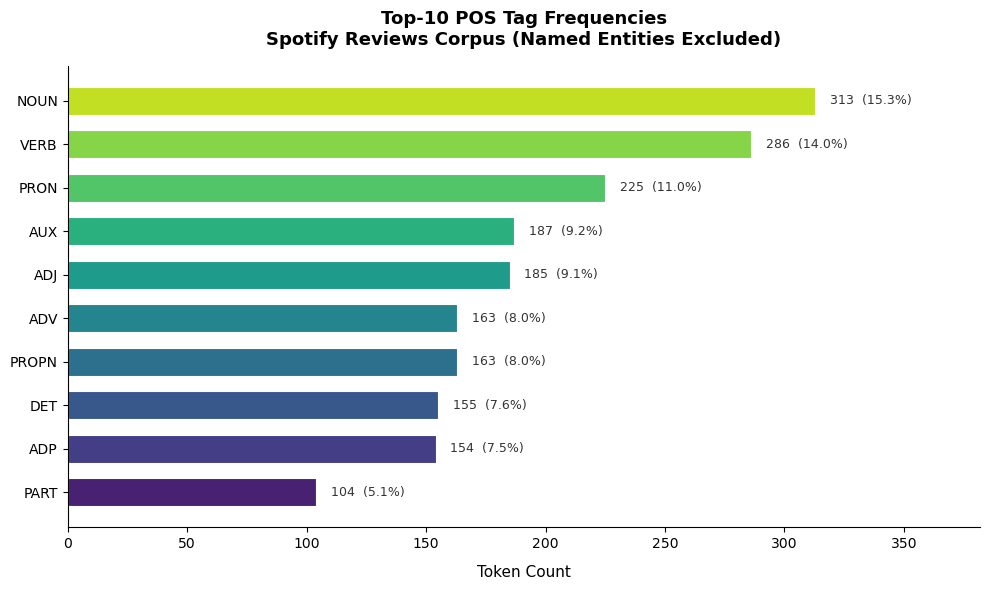

📁 Chart saved to ../Data/pos_tag_frequencies.png


In [5]:
# ── Top-10 POS Tag Frequency Bar Chart ────────────────────────────────────────

tag_counts = pos_df['pos_tag'].value_counts()
total_tokens = len(pos_df)
top10 = tag_counts.head(10)

# ── Build annotation data ──────────────────────────────────────────────────────
top10_pcts = (top10 / total_tokens * 100).round(2)

fig, ax = plt.subplots(figsize=(10, 6))

# Color palette
palette = sns.color_palette("viridis", len(top10))
bars = ax.barh(
    top10.index[::-1],
    top10.values[::-1],
    color=palette,
    edgecolor='white',
    linewidth=0.8,
    height=0.65,
)

# ── Annotate bars ──────────────────────────────────────────────────────────────
for bar, tag in zip(bars, top10.index[::-1]):
    count = top10[tag]
    pct   = top10_pcts[tag]
    ax.text(
        bar.get_width() + total_tokens * 0.003,
        bar.get_y() + bar.get_height() / 2,
        f"{count:,}  ({pct:.1f}%)",
        va='center', ha='left',
        fontsize=9, color='#333333'
    )

# ── Styling ────────────────────────────────────────────────────────────────────
ax.set_xlabel("Token Count", fontsize=11, labelpad=10)
ax.set_title(
    "Top-10 POS Tag Frequencies\nSpotify Reviews Corpus (Named Entities Excluded)",
    fontsize=13, fontweight='bold', pad=15
)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', labelsize=10)
ax.set_xlim(0, top10.max() * 1.22)

plt.tight_layout()
plt.savefig('../Data/pos_tag_frequencies.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📁 Chart saved to ../Data/pos_tag_frequencies.png")

## 3️⃣ Compute Per-Sentence Tag Diversity

For each sentence, compute the number of unique POS tags (tag diversity score). Sentences that span more POS categories tend to be syntactically richer. We identify the highest- and lowest-diversity sentences as qualitative examples.

In [6]:
# ── Per-Sentence Tag Diversity Score ──────────────────────────────────────────

sent_diversity = (
    pos_df
    .groupby(['doc_id', 'sentence_id', 'sentence'])['pos_tag']
    .agg(
        unique_tags   = 'nunique',
        total_tokens  = 'count',
        tag_list      = lambda x: list(x),
    )
    .reset_index()
)

# Rename for clarity
sent_diversity.rename(columns={'unique_tags': 'diversity_score'}, inplace=True)

# ── Summary Statistics ─────────────────────────────────────────────────────────
print("=" * 60)
print("📊 Per-Sentence Tag Diversity Statistics")
print("=" * 60)

desc = sent_diversity['diversity_score'].describe()
print(f"\n  Count     : {desc['count']:>8,.0f} sentences")
print(f"  Mean      : {desc['mean']:>8.2f} unique tags")
print(f"  Median    : {sent_diversity['diversity_score'].median():>8.2f} unique tags")
print(f"  Std Dev   : {desc['std']:>8.2f}")
print(f"  Min       : {desc['min']:>8.0f}")
print(f"  25th pct  : {desc['25%']:>8.0f}")
print(f"  75th pct  : {desc['75%']:>8.0f}")
print(f"  Max       : {desc['max']:>8.0f}")

📊 Per-Sentence Tag Diversity Statistics

  Count     :      211 sentences
  Mean      :     5.88 unique tags
  Median    :     6.00 unique tags
  Std Dev   :     2.74
  Min       :        1
  25th pct  :        4
  75th pct  :        8
  Max       :       12


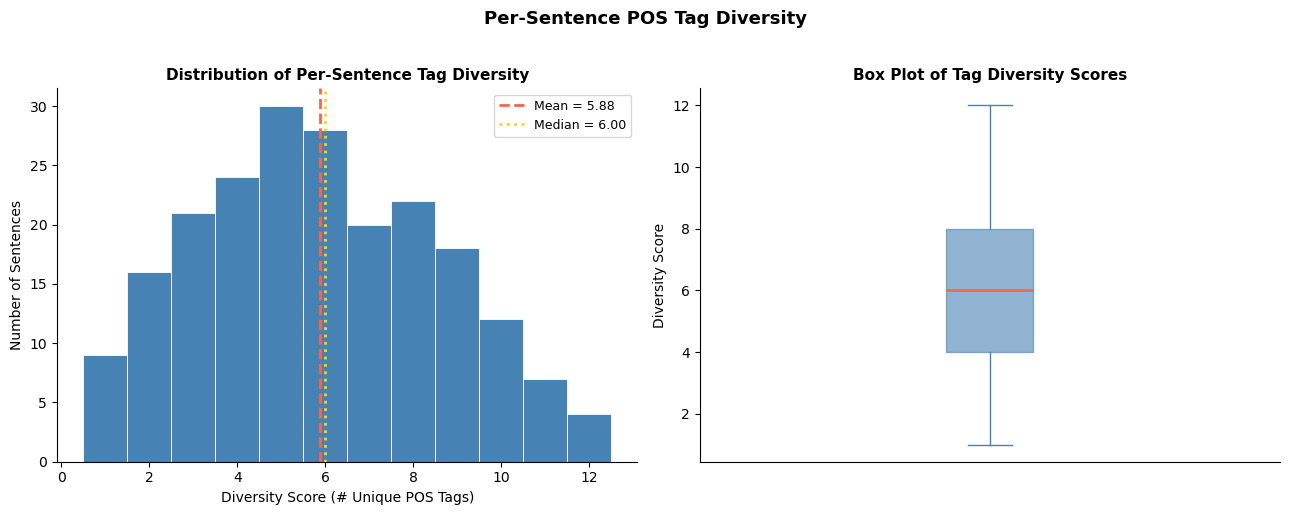

📁 Chart saved to ../Data/pos_diversity_distribution.png


In [7]:
# ── Diversity Score Distribution Plot ─────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Histogram ---
axes[0].hist(
    sent_diversity['diversity_score'],
    bins=range(1, sent_diversity['diversity_score'].max() + 2),
    color='steelblue', edgecolor='white', linewidth=0.6, align='left'
)
axes[0].axvline(
    sent_diversity['diversity_score'].mean(),
    color='tomato', linewidth=2, linestyle='--',
    label=f"Mean = {sent_diversity['diversity_score'].mean():.2f}"
)
axes[0].axvline(
    sent_diversity['diversity_score'].median(),
    color='gold', linewidth=2, linestyle=':',
    label=f"Median = {sent_diversity['diversity_score'].median():.2f}"
)
axes[0].set_xlabel("Diversity Score (# Unique POS Tags)", fontsize=10)
axes[0].set_ylabel("Number of Sentences", fontsize=10)
axes[0].set_title("Distribution of Per-Sentence Tag Diversity", fontsize=11, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].spines[['top', 'right']].set_visible(False)

# --- Box plot ---
axes[1].boxplot(
    sent_diversity['diversity_score'],
    vert=True, patch_artist=True,
    boxprops=dict(facecolor='steelblue', color='steelblue', alpha=0.6),
    medianprops=dict(color='tomato', linewidth=2),
    whiskerprops=dict(color='steelblue'),
    capprops=dict(color='steelblue'),
    flierprops=dict(marker='o', color='grey', alpha=0.3, markersize=3),
)
axes[1].set_ylabel("Diversity Score", fontsize=10)
axes[1].set_title("Box Plot of Tag Diversity Scores", fontsize=11, fontweight='bold')
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].set_xticks([])

plt.suptitle("Per-Sentence POS Tag Diversity", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../Data/pos_diversity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("📁 Chart saved to ../Data/pos_diversity_distribution.png")

In [8]:
# ── Highest & Lowest Diversity Sentence Examples ───────────────────────────────

print("=" * 80)
print("🔝 Top-5 Sentences with HIGHEST Tag Diversity")
print("=" * 80)

high_div = sent_diversity.nlargest(5, 'diversity_score')
for _, row in high_div.iterrows():
    tag_counter = Counter(row['tag_list'])
    tag_summary = ', '.join(f"{t}:{c}" for t, c in tag_counter.most_common())
    print(f"\n  Diversity Score : {row['diversity_score']} unique tags | {row['total_tokens']} tokens")
    print(f"  Tags Found      : {tag_summary}")
    print(f"  Sentence        : \"{row['sentence'][:120]}\"")

print("\n" + "=" * 80)
print("🔻 Top-5 Sentences with LOWEST Tag Diversity (min 4 tokens)")
print("=" * 80)

low_div = (
    sent_diversity[sent_diversity['total_tokens'] >= 4]
    .nsmallest(5, 'diversity_score')
)
for _, row in low_div.iterrows():
    tag_counter = Counter(row['tag_list'])
    tag_summary = ', '.join(f"{t}:{c}" for t, c in tag_counter.most_common())
    print(f"\n  Diversity Score : {row['diversity_score']} unique tags | {row['total_tokens']} tokens")
    print(f"  Tags Found      : {tag_summary}")
    print(f"  Sentence        : \"{row['sentence'][:120]}\"")

🔝 Top-5 Sentences with HIGHEST Tag Diversity

  Diversity Score : 12 unique tags | 67 tokens
  Tags Found      : NOUN:14, VERB:9, PRON:7, PART:6, PROPN:5, ADP:5, DET:4, AUX:4, ADV:4, ADJ:4, CCONJ:4, SCONJ:1
  Sentence        : "This APP Is totally focused on selling PREMIUM plans And Not providing services , ads And ads And ads 👏🏻 , these things "

  Diversity Score : 12 unique tags | 58 tokens
  Tags Found      : VERB:10, NOUN:7, ADJ:6, AUX:6, ADV:6, ADP:6, PRON:5, CCONJ:4, PROPN:3, PART:2, DET:2, SCONJ:1
  Sentence        : "New update Is horrible , Why switch tapping back To PREMIUM , And Play in order , people will be exhausted BY It , They "

  Diversity Score : 12 unique tags | 41 tokens
  Tags Found      : PRON:6, VERB:6, DET:5, NOUN:4, AUX:4, SCONJ:3, PROPN:3, PART:3, ADJ:3, ADV:2, CCONJ:1, ADP:1
  Sentence        : "After The New update Everything Is Because wrost You cannot Even Play a SONG specific part It Is become Useless If They "

  Diversity Score : 12 unique tags | 38 

## 4️⃣ Select Representative Sentences per Major Tag Type

For each major POS tag (`NOUN`, `VERB`, `ADJ`, `ADV`, `PROPN`), select the 5 representative sentences where that tag is most dominant — i.e., the highest ratio of that tag among all tokens in the sentence. Results are displayed as a formatted table showing: tag type, tag ratio, and sentence text.

In [9]:
# ── Per-Sentence Tag Ratio Calculation ────────────────────────────────────────

MAJOR_TAGS = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']

def compute_tag_ratio(tag_list: list, target_tag: str) -> float:
    """Fraction of tokens in a sentence that carry the target POS tag."""
    if not tag_list:
        return 0.0
    return tag_list.count(target_tag) / len(tag_list)

# Add ratio columns for each major tag
for tag in MAJOR_TAGS:
    col_name = f'ratio_{tag.lower()}'
    sent_diversity[col_name] = sent_diversity['tag_list'].apply(
        lambda tl: compute_tag_ratio(tl, tag)
    )

print("=" * 60)
print("✅ Tag Ratio Columns Added")
print("=" * 60)
ratio_cols = [f'ratio_{t.lower()}' for t in MAJOR_TAGS]
print(sent_diversity[ratio_cols].describe().round(3))

✅ Tag Ratio Columns Added
       ratio_noun  ratio_verb  ratio_adj  ratio_adv  ratio_propn
count     211.000     211.000    211.000    211.000      211.000
mean        0.147       0.119      0.112      0.088        0.119
std         0.129       0.106      0.153      0.122        0.201
min         0.000       0.000      0.000      0.000        0.000
25%         0.000       0.000      0.000      0.000        0.000
50%         0.143       0.125      0.077      0.043        0.050
75%         0.222       0.179      0.154      0.143        0.167
max         0.750       0.500      1.000      0.667        1.000


In [10]:
# ── Representative Sentences per Tag Type ─────────────────────────────────────

MIN_TOKENS = 5        # Minimum tokens to avoid trivial single-word sentences
TOP_N      = 5        # Number of representative sentences per tag

print("=" * 100)
print("🏆 Top-5 Representative Sentences per Major POS Tag")
print("   (Ranked by highest ratio of target tag among sentence tokens)")
print("=" * 100)

tag_emojis = {
    'NOUN' : '📦',
    'VERB' : '⚙️ ',
    'ADJ'  : '✨',
    'ADV'  : '💨',
    'PROPN': '🏷️ ',
}

all_rows = []   # Collect for final combined table

for tag in MAJOR_TAGS:
    ratio_col = f'ratio_{tag.lower()}'

    top_sents = (
        sent_diversity[sent_diversity['total_tokens'] >= MIN_TOKENS]
        .nlargest(TOP_N, ratio_col)
        [['sentence', ratio_col, 'total_tokens', 'diversity_score']]
        .reset_index(drop=True)
    )

    emoji = tag_emojis.get(tag, '🔹')
    print(f"\n{emoji}  POS Tag: {tag}")
    print("-" * 100)
    print(f"  {'#':<3} {'Tag Ratio':>10} {'Tokens':>7} {'Diversity':>10}   Sentence")
    print(f"  {'-'*3} {'-'*10} {'-'*7} {'-'*10}   {'-'*60}")

    for rank, (_, row) in enumerate(top_sents.iterrows(), 1):
        sentence_preview = row['sentence'][:80] + ('…' if len(row['sentence']) > 80 else '')
        print(
            f"  {rank:<3} {row[ratio_col]:>9.1%} "
            f"{row['total_tokens']:>7} "
            f"{row['diversity_score']:>10}   "
            f"\"{sentence_preview}\""
        )
        all_rows.append({
            'POS Tag'   : tag,
            'Rank'      : rank,
            'Tag Ratio' : round(row[ratio_col], 4),
            'Tokens'    : row['total_tokens'],
            'Diversity' : row['diversity_score'],
            'Sentence'  : row['sentence'],
        })

print("\n" + "=" * 100)
print("✅ Representative sentence extraction complete.")

🏆 Top-5 Representative Sentences per Major POS Tag
   (Ranked by highest ratio of target tag among sentence tokens)

📦  POS Tag: NOUN
----------------------------------------------------------------------------------------------------
  #    Tag Ratio  Tokens  Diversity   Sentence
  --- ---------- ------- ----------   ------------------------------------------------------------
  1       60.0%       5          3   "Hotch potch And flop update ..."
  2       40.0%      10          6   "Add a feature of sort Playlist on smart TV Also.."
  3       40.0%       5          4   "Excellent selection of Music And books"
  4       33.3%      12          7   "It says"watch This 30 sec ad To listen To songs for 30 mins ad free""
  5       33.3%      12          7   "But recently pushing lyrics behind a wall, No shuffling etc Is affecting experie…"

⚙️   POS Tag: VERB
----------------------------------------------------------------------------------------------------
  #    Tag Ratio  Tokens  Diver

In [11]:
# ── Combined Summary Table ─────────────────────────────────────────────────────

summary_df = pd.DataFrame(all_rows)

print("=" * 80)
print("📋 Combined Representative Sentences DataFrame")
print("=" * 80)
print(f"  Shape: {summary_df.shape}")
print(f"\n  Preview (first 15 rows):")
print(
    summary_df[['POS Tag', 'Rank', 'Tag Ratio', 'Tokens', 'Diversity', 'Sentence']]
    .head(15)
    .to_string(index=False)
)

# Save to CSV for downstream use
summary_df.to_csv('../Data/representative_sentences_per_pos.csv', index=False)
print("\n📁 Saved to ../Data/representative_sentences_per_pos.csv")

📋 Combined Representative Sentences DataFrame
  Shape: (25, 6)

  Preview (first 15 rows):
POS Tag  Rank  Tag Ratio  Tokens  Diversity                                                                              Sentence
   NOUN     1     0.6000       5          3                                                       Hotch potch And flop update ...
   NOUN     2     0.4000      10          6                                     Add a feature of sort Playlist on smart TV Also..
   NOUN     3     0.4000       5          4                                                Excellent selection of Music And books
   NOUN     4     0.3333      12          7                  It says"watch This 30 sec ad To listen To songs for 30 mins ad free"
   NOUN     5     0.3333      12          7  But recently pushing lyrics behind a wall, No shuffling etc Is affecting experience.
   VERB     1     0.5000       8          4                        One day that day will going To come when Spotify going To say.

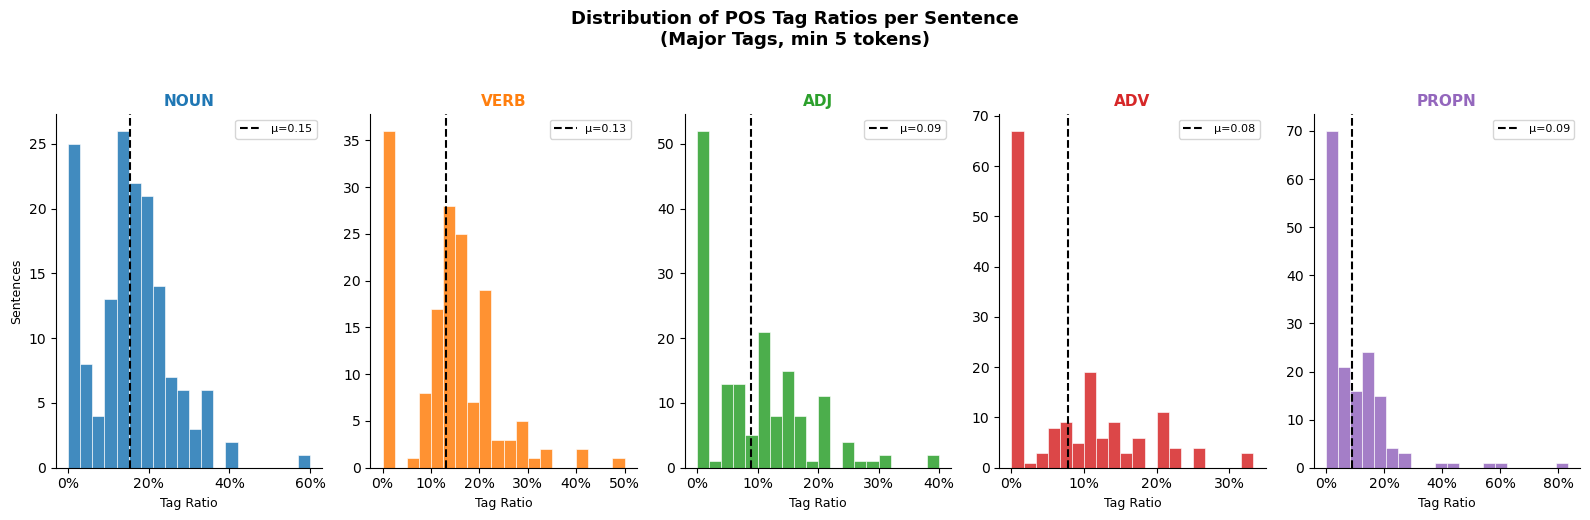

📁 Chart saved to ../Data/pos_tag_ratio_distributions.png


In [12]:
# ── Tag Ratio Distribution Plot per Major Tag ──────────────────────────────────

fig, axes = plt.subplots(1, len(MAJOR_TAGS), figsize=(16, 5), sharey=False)

colors = sns.color_palette("tab10", len(MAJOR_TAGS))

for ax, tag, color in zip(axes, MAJOR_TAGS, colors):
    ratio_col = f'ratio_{tag.lower()}'
    data = sent_diversity[sent_diversity['total_tokens'] >= MIN_TOKENS][ratio_col]

    ax.hist(data, bins=20, color=color, edgecolor='white', linewidth=0.5, alpha=0.85)
    ax.axvline(data.mean(), color='black', linewidth=1.5, linestyle='--',
               label=f"μ={data.mean():.2f}")
    ax.set_title(f"{tag}", fontsize=11, fontweight='bold', color=color)
    ax.set_xlabel("Tag Ratio", fontsize=9)
    ax.set_ylabel("Sentences" if tag == MAJOR_TAGS[0] else "", fontsize=9)
    ax.legend(fontsize=8, loc='upper right')
    ax.spines[['top', 'right']].set_visible(False)
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))

plt.suptitle(
    "Distribution of POS Tag Ratios per Sentence\n(Major Tags, min 5 tokens)",
    fontsize=13, fontweight='bold', y=1.03
)
plt.tight_layout()
plt.savefig('../Data/pos_tag_ratio_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("📁 Chart saved to ../Data/pos_tag_ratio_distributions.png")

## Summary

| Step | Output |
|------|--------|
| **1. POS Extraction** | Structured `pos_df` with `token`, `lemma`, `upos`, `fine_tag`, `sent_id` — named entities filtered out |
| **Milestone 2 Export** | `milestone2_pos_analysis.csv` — full token-level table with UPOS + Penn Treebank tags |
| **2. Tag Frequency Plot** | Horizontal bar chart of top-10 POS tags with counts & percentages |
| **3. Diversity Analysis** | Per-sentence unique-tag diversity scores with distribution plots and extreme examples |
| **4. Representative Sentences** | Top-5 sentences per major tag type (NOUN, VERB, ADJ, ADV, PROPN) ranked by tag dominance ratio |

### Key Takeaways
- **NOUN** and **VERB** dominate the corpus token distribution, as expected for app reviews.
- **ADJ** tokens are strong sentiment signals — representative sentences reveal polarity words.
- **ADV** sentences with high ratios often contain intensifiers (`really`, `always`, `never`).
- Sentences with **high diversity** (many POS types) tend to be more nuanced, multi-clause reviews.
- Sentences with **low diversity** are often very short emotional outbursts (e.g. all NOUN or all ADJ).
- **`fine_tag`** (Penn Treebank) adds tense/degree/number detail beyond UPOS — e.g. `JJR`/`JJS` are strong comparative sentiment signals.